## Import Libraries and Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import DataProcessor
import SRMSE
import VAE

In [2]:
# Load in the persons PUMS dataset for WA state
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

## Choose PUMS and Preprocess

In [3]:
# Filter to desired variables (numeric then categorical)
pums_data = h_df[['HINCP','NP','VEH','BLD','ACCESS']].copy()

# Convert numerical variables to categorical bins
pums_data['HINCP'], hincp_bins = pd.qcut(pums_data['HINCP'], q=10, labels=False, retbins=True)

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

Dataset n=164836 pre-cleaning
Dataset n=140586 post-cleaning


In [4]:
VAR_DIM = pums_data.shape[1]
VAR_NAMES = pums_data.columns

# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
pums_encodings_list = []
for x in range(VAR_DIM):
    dummies = pums_data.iloc[:,x]
    pums_encodings_list.append(np.unique(dummies.values))
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
CAT_LENGTHS = [x.shape[1] for x in dummies_list]

In [5]:
# Final data frame after encoding OHE
model_data_df = pd.DataFrame()
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
MANIFEST_DIM = model_data_df.shape[1]

# Preview data that will be fed into model
model_data_df

,HINCP__0.0,HINCP__1.0,HINCP__2.0,HINCP__3.0,HINCP__4.0,HINCP__5.0,HINCP__6.0,HINCP__7.0,HINCP__8.0,HINCP__9.0,...,BLD__4.0,BLD__5.0,BLD__6.0,BLD__7.0,BLD__8.0,BLD__9.0,BLD__10.0,ACCESS__1.0,ACCESS__2.0,ACCESS__3.0
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161771,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
161772,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
161774,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
161775,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
# Separate into train/test data
model_data = model_data_df.values
train_idx = round(len(model_data)*.03)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

print(f"Training on {train_idx} samples")

Training on 4218 samples


## Set Parameters and Define Model

In [7]:
# Grid Search 1
# BATCH_SIZES = [1024, 512, 256, 128, 64, 32]
# EPOCHS = [20]
# LATENT_DIMS = [2]
# HIDDEN_DIMS = [8,16,32,64]
# KL_WEIGHTS = [0.01,0.05,0.1,0.5]
# [14.05646538734436, <tf.Tensor: shape=(), dtype=float32, numpy=1.9191134>, <tf.Tensor: shape=(), dtype=float32, numpy=3.025887>, KstestResult(statistic=0.5773528502126812, pvalue=0.0), Power_divergenceResult(statistic=122581.11806601255, pvalue=0.0), [1024, 20, 2, 32, 0.01]]
# [11.231985330581665, <tf.Tensor: shape=(), dtype=float32, numpy=40.03866>, <tf.Tensor: shape=(), dtype=float32, numpy=4.05524>, KstestResult(statistic=0.41753790846883754, pvalue=0.0), Power_divergenceResult(statistic=122300.09878929473, pvalue=0.0), [1024, 20, 2, 8, 0.01]]
# [11.231985330581665, <tf.Tensor: shape=(), dtype=float32, numpy=40.03866>, <tf.Tensor: shape=(), dtype=float32, numpy=4.05524>, KstestResult(statistic=0.41753790846883754, pvalue=0.0), Power_divergenceResult(statistic=122300.09878929473, pvalue=0.0), [1024, 20, 2, 8, 0.01]]

# Grid Search 2
# BATCH_SIZES = [4096, 2048, 1024, 512]
# EPOCHS = [20, 40]
# LATENT_DIMS = [2]
# HIDDEN_DIMS = [4, 8, 16, 32]
# KL_WEIGHTS = [.001, .005, 0.01, 0.05]
# [26.794755935668945, <tf.Tensor: shape=(), dtype=float32, numpy=2.0033364>, <tf.Tensor: shape=(), dtype=float32, numpy=2.1165783>, KstestResult(statistic=0.6072337345112601, pvalue=0.0), Power_divergenceResult(statistic=122765.4937961509, pvalue=0.0), [1024, 40, 2, 32, 0.005]]
# [7.162848949432373, <tf.Tensor: shape=(), dtype=float32, numpy=42.918358>, <tf.Tensor: shape=(), dtype=float32, numpy=5.0970073>, KstestResult(statistic=0.3970379084688376, pvalue=0.0), Power_divergenceResult(statistic=123332.1501197664, pvalue=0.0), [4096, 20, 2, 4, 0.001]]
# [7.162848949432373, <tf.Tensor: shape=(), dtype=float32, numpy=42.918358>, <tf.Tensor: shape=(), dtype=float32, numpy=5.0970073>, KstestResult(statistic=0.3970379084688376, pvalue=0.0), Power_divergenceResult(statistic=123332.1501197664, pvalue=0.0), [4096, 20, 2, 4, 0.001]]

# Grid Search 3
# BATCH_SIZES = [2048, 1024, 512]
# EPOCHS = [100]
# LATENT_DIMS = [2]
# HIDDEN_DIMS = [8, 16, 32]
# KL_WEIGHTS = [.001, .005, .01, .03, .05, .07, .1]
# NUM_WEIGHTS = [1, 5, 10, 15, 20]
# [69.22298073768616, <tf.Tensor: shape=(), dtype=float32, numpy=0.7053668>, <tf.Tensor: shape=(), dtype=float32, numpy=2.433684>, KstestResult(statistic=0.3483799112287141, pvalue=0.0), Power_divergenceResult(statistic=121453.35289829638, pvalue=0.0), [512, 100, 2, 16, 0.03, 20]]
# [39.46292066574097, <tf.Tensor: shape=(), dtype=float32, numpy=4.3707395>, <tf.Tensor: shape=(), dtype=float32, numpy=3.2804358>, KstestResult(statistic=0.6909941373963269, pvalue=0.0), Power_divergenceResult(statistic=121742.847546511, pvalue=0.0), [2048, 100, 2, 8, 0.001, 1]]
# [39.46292066574097, <tf.Tensor: shape=(), dtype=float32, numpy=4.3707395>, <tf.Tensor: shape=(), dtype=float32, numpy=3.2804358>, KstestResult(statistic=0.6909941373963269, pvalue=0.0), Power_divergenceResult(statistic=121742.847546511, pvalue=0.0), [2048, 100, 2, 8, 0.001, 1]]

# Grid Search 4
# BATCH_SIZES = [512]
# EPOCHS = [100]
# LATENT_DIMS = [3]
# HIDDEN_DIMS = [8, 16, 32]
# KL_WEIGHTS = [.05, .1, .5, 1.0]
# NUM_WEIGHTS = [.5, 1, 2, 5, 10, 15]
# [90.3771698474884, <tf.Tensor: shape=(), dtype=float32, numpy=1.9142284>, <tf.Tensor: shape=(), dtype=float32, numpy=0.91689825>, KstestResult(statistic=0.2516518330416969, pvalue=0.0), Power_divergenceResult(statistic=121336.76842914447, pvalue=0.0), [512, 100, 3, 32, 0.05, 2]]
# [67.4782133102417, <tf.Tensor: shape=(), dtype=float32, numpy=8.163122>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3749605>, KstestResult(statistic=0.27553862404506846, pvalue=0.0), Power_divergenceResult(statistic=121310.24485971738, pvalue=0.0), [512, 100, 3, 8, 0.05, 0.5]]
# [67.4782133102417, <tf.Tensor: shape=(), dtype=float32, numpy=8.163122>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3749605>, KstestResult(statistic=0.27553862404506846, pvalue=0.0), Power_divergenceResult(statistic=121310.24485971738, pvalue=0.0), [512, 100, 3, 8, 0.05, 0.5]]

BATCH_SIZE = 512
EPOCHS = 1000
LATENT_DIM = 3
HIDDEN_DIM = 16
KL_WEIGHT = .05

# Best results so far:
# As the training size gets smaller, KL weight should decrease [.01-.1 seems good range]
# BATCH_SIZE = 512
# EPOCHS = 100
# LATENT_DIM = 3
# HIDDEN_DIM = 16
# KL_WEIGHT = .05
# NUM_WEIGHT = 2

# BATCH_SIZE = 512
# EPOCHS = 100
# LATENT_DIM = 3
# HIDDEN_DIM = 32
# KL_WEIGHT = .05
# NUM_WEIGHT = 2

# BATCH_SIZE = 512
# EPOCHS = 100
# LATENT_DIM = 3
# HIDDEN_DIM = 16
# KL_WEIGHT = .1
# NUM_WEIGHT = 2

# BATCH_SIZE = 512
# EPOCHS = 100
# LATENT_DIM = 2
# HIDDEN_DIM = 16
# KL_WEIGHT = .04
# NUM_WEIGHT = 10

# # Borysov
# BATCH_SIZE = 64
# EPOCHS = 10
# LEARN_RATE = 0.001
# RHO = 0.9
# LATENT_DIM = 5
# HIDDEN_DIM = 100
# KL_WEIGHT = 0.5

# Lower KLLW gives better reconstruction on the test data
# Too low KLLW gives nonsense in the synthesis
# Get KLLW as low as possible before synthesis suffers

## Training

In [8]:
# # Use grid search to train model and get results for many different hyperparameters
# grid_search_results = []
# for bs in BATCH_SIZES:
#     for e in EPOCHS:
#         for ld in LATENT_DIMS:
#             for hd in HIDDEN_DIMS:
#                 for klw in KL_WEIGHTS:
#                     for nw in NUM_WEIGHTS:
#                         start_time = time.time()
#                         LEN_HH = 0
#                         vae = VAE.VAE(MANIFEST_DIM, hd, ld, CAT_LENGTHS, CAT_IDX, LEN_HH, klw, nw)
#                         vae.compile(optimizer=keras.optimizers.Adam())
#                         history = vae.fit(train_data, epochs=e, batch_size=bs)
#                         train_time = (time.time()-start_time)
#                         loss_num, loss_cat, ks_test, chisq_test = test_model(vae, ld)
#                         results = [train_time, loss_num, loss_cat, ks_test, chisq_test, [bs,e,ld,hd,klw,nw]]
#                         grid_search_results.append(results)
# # results = [train_time, loss_num, loss_cat, ks_test, chisq_test, [bs,e,ld,hd,klw]]
# min_rec = 0
# min_ks = 0
# min_chisq = 0
# min_rec_value = 999999999
# min_ks_value = 999999999
# min_chisq_value = 999999999
# for i, result in enumerate(grid_search_results):
#     if result[1]+result[2] < min_rec_value:
#         min_rec = i
#         min_rec_value = result[1]+result[2]
#     if result[3][1] < min_ks_value:
#         min_ks = i
#         min_ks_value = result[3][1]
#     if result[4][1] < min_chisq_value:
#         min_chisq = i
#         min_chisq_value = result[4][1]
# print(grid_search_results[min_rec])
# print(grid_search_results[min_ks])
# print(grid_search_results[min_chisq])

In [9]:
val_loss = []
val_epochs = []
class validationCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            val_epochs.append(epoch)
            # Use random sample of 1000 from test data to validate the model
            idx = np.random.randint(test_data.shape[0], size=1000)
            val_data = test_data[idx]
            results = vae.predict(val_data)
            loss_cat = VAE.get_reconstruction_loss(val_data, results, CAT_LENGTHS)
            val_loss.append(loss_cat)

In [10]:
# Train the model using single set of hyperparameters
HH_IDX = len(CAT_LENGTHS)  # Number of household variables (used in CVAE)
start_time = time.time()

vae = VAE.VAE(MANIFEST_DIM, HIDDEN_DIM, LATENT_DIM, CAT_LENGTHS, HH_IDX, KL_WEIGHT)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[validationCallback()])

train_time = (time.time()-start_time)
print(train_time)

Epoch 1/1000
9/9 [==============================] - 0s 26ms/step - tot_loss: 10.9131 - rec_loss: 10.8892 - kl_loss: 0.0239
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - tot_loss: 10.5399 - rec_loss: 10.5099 - kl_loss: 0.0299
Epoch 3/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 10.1576 - rec_loss: 10.1150 - kl_loss: 0.0426
Epoch 4/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 9.7671 - rec_loss: 9.7057 - kl_loss: 0.0614
Epoch 5/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 9.3439 - rec_loss: 9.2570 - kl_loss: 0.0868
Epoch 6/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 8.9456 - rec_loss: 8.8296 - kl_loss: 0.1160
Epoch 7/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 8.5478 - rec_loss: 8.4066 - kl_loss: 0.1412
Epoch 8/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 8.2088 - rec_loss: 8.0536 - kl_loss: 0.1552
Epoch 9/1000
9/9 [===============

9/9 [==============================] - 0s 2ms/step - tot_loss: 4.8165 - rec_loss: 4.5524 - kl_loss: 0.2641
Epoch 69/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 4.8321 - rec_loss: 4.5672 - kl_loss: 0.2649
Epoch 70/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 4.7966 - rec_loss: 4.5300 - kl_loss: 0.2667
Epoch 71/1000
9/9 [==============================] - 0s 7ms/step - tot_loss: 4.7703 - rec_loss: 4.5030 - kl_loss: 0.2673
Epoch 72/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 4.7594 - rec_loss: 4.4913 - kl_loss: 0.2682
Epoch 73/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 4.7372 - rec_loss: 4.4681 - kl_loss: 0.2691
Epoch 74/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 4.7347 - rec_loss: 4.4649 - kl_loss: 0.2698
Epoch 75/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 4.6867 - rec_loss: 4.4153 - kl_loss: 0.2714
Epoch 76/1000
9/9 [===========================

Epoch 135/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 4.1034 - rec_loss: 3.7947 - kl_loss: 0.3087
Epoch 136/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 4.0215 - rec_loss: 3.7118 - kl_loss: 0.3097
Epoch 137/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 4.0343 - rec_loss: 3.7240 - kl_loss: 0.3103
Epoch 138/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 4.0350 - rec_loss: 3.7246 - kl_loss: 0.3104
Epoch 139/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 4.0023 - rec_loss: 3.6932 - kl_loss: 0.3091
Epoch 140/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 4.0391 - rec_loss: 3.7284 - kl_loss: 0.3108
Epoch 141/1000
9/9 [==============================] - 0s 8ms/step - tot_loss: 4.0089 - rec_loss: 3.6974 - kl_loss: 0.3115
Epoch 142/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 4.0085 - rec_loss: 3.6961 - kl_loss: 0.3123
Epoch 143/1000
9/9 [====

9/9 [==============================] - 0s 2ms/step - tot_loss: 3.4988 - rec_loss: 3.1557 - kl_loss: 0.3430
Epoch 203/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 3.4549 - rec_loss: 3.1129 - kl_loss: 0.3420
Epoch 204/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 3.4512 - rec_loss: 3.1074 - kl_loss: 0.3438
Epoch 205/1000
9/9 [==============================] - 0s 3ms/step - tot_loss: 3.4796 - rec_loss: 3.1353 - kl_loss: 0.3443
Epoch 206/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 3.4323 - rec_loss: 3.0874 - kl_loss: 0.3449
Epoch 207/1000
9/9 [==============================] - 0s 3ms/step - tot_loss: 3.4503 - rec_loss: 3.1053 - kl_loss: 0.3450
Epoch 208/1000
9/9 [==============================] - 0s 4ms/step - tot_loss: 3.4375 - rec_loss: 3.0920 - kl_loss: 0.3455
Epoch 209/1000
9/9 [==============================] - 0s 4ms/step - tot_loss: 3.4345 - rec_loss: 3.0881 - kl_loss: 0.3464
Epoch 210/1000
9/9 [===================

9/9 [==============================] - 0s 2ms/step - tot_loss: 2.9564 - rec_loss: 2.5851 - kl_loss: 0.3713
Epoch 270/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.9543 - rec_loss: 2.5833 - kl_loss: 0.3709
Epoch 271/1000
9/9 [==============================] - 0s 8ms/step - tot_loss: 2.9594 - rec_loss: 2.5878 - kl_loss: 0.3716
Epoch 272/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.9433 - rec_loss: 2.5707 - kl_loss: 0.3727
Epoch 273/1000
9/9 [==============================] - 0s 3ms/step - tot_loss: 2.9254 - rec_loss: 2.5519 - kl_loss: 0.3735
Epoch 274/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.9497 - rec_loss: 2.5758 - kl_loss: 0.3739
Epoch 275/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.9281 - rec_loss: 2.5538 - kl_loss: 0.3743
Epoch 276/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.9329 - rec_loss: 2.5581 - kl_loss: 0.3748
Epoch 277/1000
9/9 [===================

9/9 [==============================] - 0s 4ms/step - tot_loss: 2.6302 - rec_loss: 2.2439 - kl_loss: 0.3862
Epoch 337/1000
9/9 [==============================] - 0s 6ms/step - tot_loss: 2.6154 - rec_loss: 2.2295 - kl_loss: 0.3859
Epoch 338/1000
9/9 [==============================] - 0s 3ms/step - tot_loss: 2.6195 - rec_loss: 2.2339 - kl_loss: 0.3855
Epoch 339/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.6030 - rec_loss: 2.2170 - kl_loss: 0.3860
Epoch 340/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.5983 - rec_loss: 2.2117 - kl_loss: 0.3867
Epoch 341/1000
9/9 [==============================] - 0s 8ms/step - tot_loss: 2.5830 - rec_loss: 2.1968 - kl_loss: 0.3862
Epoch 342/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.5954 - rec_loss: 2.2099 - kl_loss: 0.3855
Epoch 343/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.5777 - rec_loss: 2.1922 - kl_loss: 0.3855
Epoch 344/1000
9/9 [===================

9/9 [==============================] - 0s 3ms/step - tot_loss: 2.3736 - rec_loss: 1.9775 - kl_loss: 0.3961
Epoch 404/1000
9/9 [==============================] - 0s 3ms/step - tot_loss: 2.3482 - rec_loss: 1.9508 - kl_loss: 0.3975
Epoch 405/1000
9/9 [==============================] - 0s 3ms/step - tot_loss: 2.3640 - rec_loss: 1.9662 - kl_loss: 0.3977
Epoch 406/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.3447 - rec_loss: 1.9484 - kl_loss: 0.3963
Epoch 407/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.3614 - rec_loss: 1.9648 - kl_loss: 0.3966
Epoch 408/1000
9/9 [==============================] - 0s 3ms/step - tot_loss: 2.3582 - rec_loss: 1.9629 - kl_loss: 0.3953
Epoch 409/1000
9/9 [==============================] - 0s 3ms/step - tot_loss: 2.3384 - rec_loss: 1.9438 - kl_loss: 0.3946
Epoch 410/1000
9/9 [==============================] - 0s 3ms/step - tot_loss: 2.3704 - rec_loss: 1.9759 - kl_loss: 0.3945
Epoch 411/1000
9/9 [===================

9/9 [==============================] - 0s 2ms/step - tot_loss: 2.1974 - rec_loss: 1.7931 - kl_loss: 0.4044
Epoch 471/1000
9/9 [==============================] - 0s 8ms/step - tot_loss: 2.2016 - rec_loss: 1.7979 - kl_loss: 0.4037
Epoch 472/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.1788 - rec_loss: 1.7754 - kl_loss: 0.4034
Epoch 473/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.1949 - rec_loss: 1.7897 - kl_loss: 0.4052
Epoch 474/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.1795 - rec_loss: 1.7738 - kl_loss: 0.4057
Epoch 475/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.1617 - rec_loss: 1.7551 - kl_loss: 0.4065
Epoch 476/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.2066 - rec_loss: 1.8006 - kl_loss: 0.4060
Epoch 477/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.1854 - rec_loss: 1.7773 - kl_loss: 0.4081
Epoch 478/1000
9/9 [===================

9/9 [==============================] - 0s 3ms/step - tot_loss: 2.0542 - rec_loss: 1.6355 - kl_loss: 0.4187
Epoch 538/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.0495 - rec_loss: 1.6314 - kl_loss: 0.4181
Epoch 539/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.0620 - rec_loss: 1.6428 - kl_loss: 0.4192
Epoch 540/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.0540 - rec_loss: 1.6362 - kl_loss: 0.4177
Epoch 541/1000
9/9 [==============================] - 0s 8ms/step - tot_loss: 2.0585 - rec_loss: 1.6423 - kl_loss: 0.4162
Epoch 542/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.0546 - rec_loss: 1.6381 - kl_loss: 0.4165
Epoch 543/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.0168 - rec_loss: 1.6009 - kl_loss: 0.4159
Epoch 544/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 2.0458 - rec_loss: 1.6292 - kl_loss: 0.4166
Epoch 545/1000
9/9 [===================

9/9 [==============================] - 0s 2ms/step - tot_loss: 1.9398 - rec_loss: 1.5135 - kl_loss: 0.4263
Epoch 605/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.9208 - rec_loss: 1.4945 - kl_loss: 0.4263
Epoch 606/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.9266 - rec_loss: 1.4988 - kl_loss: 0.4279
Epoch 607/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.9200 - rec_loss: 1.4921 - kl_loss: 0.4279
Epoch 608/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.9282 - rec_loss: 1.5022 - kl_loss: 0.4260
Epoch 609/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.9220 - rec_loss: 1.4970 - kl_loss: 0.4250
Epoch 610/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.9313 - rec_loss: 1.5055 - kl_loss: 0.4258
Epoch 611/1000
9/9 [==============================] - 0s 9ms/step - tot_loss: 1.9093 - rec_loss: 1.4824 - kl_loss: 0.4269
Epoch 612/1000
9/9 [===================

9/9 [==============================] - 0s 7ms/step - tot_loss: 1.8404 - rec_loss: 1.4062 - kl_loss: 0.4342
Epoch 672/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.8510 - rec_loss: 1.4180 - kl_loss: 0.4330
Epoch 673/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.8326 - rec_loss: 1.3998 - kl_loss: 0.4328
Epoch 674/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.8399 - rec_loss: 1.4076 - kl_loss: 0.4322
Epoch 675/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.8393 - rec_loss: 1.4065 - kl_loss: 0.4329
Epoch 676/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.8349 - rec_loss: 1.4017 - kl_loss: 0.4332
Epoch 677/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.8173 - rec_loss: 1.3845 - kl_loss: 0.4329
Epoch 678/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.8299 - rec_loss: 1.3968 - kl_loss: 0.4331
Epoch 679/1000
9/9 [===================

9/9 [==============================] - 0s 2ms/step - tot_loss: 1.7696 - rec_loss: 1.3311 - kl_loss: 0.4385
Epoch 739/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.7750 - rec_loss: 1.3362 - kl_loss: 0.4388
Epoch 740/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.7753 - rec_loss: 1.3374 - kl_loss: 0.4378
Epoch 741/1000
9/9 [==============================] - 0s 8ms/step - tot_loss: 1.7480 - rec_loss: 1.3095 - kl_loss: 0.4386
Epoch 742/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.7708 - rec_loss: 1.3323 - kl_loss: 0.4385
Epoch 743/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.7604 - rec_loss: 1.3212 - kl_loss: 0.4392
Epoch 744/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.7541 - rec_loss: 1.3137 - kl_loss: 0.4404
Epoch 745/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.7613 - rec_loss: 1.3228 - kl_loss: 0.4385
Epoch 746/1000
9/9 [===================

9/9 [==============================] - 0s 2ms/step - tot_loss: 1.7097 - rec_loss: 1.2705 - kl_loss: 0.4392
Epoch 806/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.7008 - rec_loss: 1.2600 - kl_loss: 0.4407
Epoch 807/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.7089 - rec_loss: 1.2668 - kl_loss: 0.4421
Epoch 808/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.7127 - rec_loss: 1.2699 - kl_loss: 0.4427
Epoch 809/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.6727 - rec_loss: 1.2305 - kl_loss: 0.4421
Epoch 810/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.7031 - rec_loss: 1.2607 - kl_loss: 0.4424
Epoch 811/1000
9/9 [==============================] - 0s 8ms/step - tot_loss: 1.6827 - rec_loss: 1.2406 - kl_loss: 0.4421
Epoch 812/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.6829 - rec_loss: 1.2431 - kl_loss: 0.4398
Epoch 813/1000
9/9 [===================

9/9 [==============================] - 0s 3ms/step - tot_loss: 1.6252 - rec_loss: 1.1817 - kl_loss: 0.4435
Epoch 873/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.6457 - rec_loss: 1.2017 - kl_loss: 0.4441
Epoch 874/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.6503 - rec_loss: 1.2056 - kl_loss: 0.4447
Epoch 875/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.6426 - rec_loss: 1.1976 - kl_loss: 0.4450
Epoch 876/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.6426 - rec_loss: 1.1972 - kl_loss: 0.4455
Epoch 877/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.6516 - rec_loss: 1.2071 - kl_loss: 0.4445
Epoch 878/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.6436 - rec_loss: 1.1979 - kl_loss: 0.4456
Epoch 879/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.6412 - rec_loss: 1.1959 - kl_loss: 0.4454
Epoch 880/1000
9/9 [===================

9/9 [==============================] - 0s 2ms/step - tot_loss: 1.6153 - rec_loss: 1.1663 - kl_loss: 0.4490
Epoch 940/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.5765 - rec_loss: 1.1299 - kl_loss: 0.4465
Epoch 941/1000
9/9 [==============================] - 0s 7ms/step - tot_loss: 1.5782 - rec_loss: 1.1329 - kl_loss: 0.4453
Epoch 942/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.5872 - rec_loss: 1.1421 - kl_loss: 0.4451
Epoch 943/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.5740 - rec_loss: 1.1297 - kl_loss: 0.4443
Epoch 944/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.5692 - rec_loss: 1.1221 - kl_loss: 0.4471
Epoch 945/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.5833 - rec_loss: 1.1361 - kl_loss: 0.4472
Epoch 946/1000
9/9 [==============================] - 0s 2ms/step - tot_loss: 1.5964 - rec_loss: 1.1482 - kl_loss: 0.4481
Epoch 947/1000
9/9 [===================

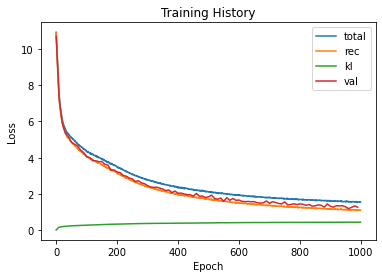

In [11]:
# Plot model loss/training progress
plt.plot(history.history['tot_loss'])
plt.plot(history.history['rec_loss'])
plt.plot(history.history['kl_loss'])
plt.plot(val_epochs, val_loss)
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","rec","kl","val"], loc="upper right")
plt.show()

## Testing

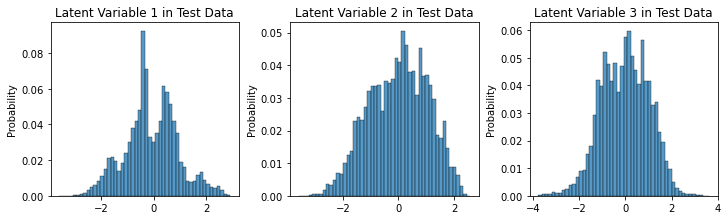

In [12]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=1, ncols=LATENT_DIM, figsize=(10,3))
fig.tight_layout(w_pad=2, h_pad=10)

for i in range(LATENT_DIM):
    sns.histplot(z[:,i], ax=axes[i], bins=50, stat="probability")
    axes[i].set_title(f"Latent Variable {i+1} in Test Data")

In [13]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_cat = VAE.get_reconstruction_loss(test_data, results, CAT_LENGTHS)
print(f"Categorical Variable Loss: {loss_cat}")

Categorical Variable Loss: 1.2683080434799194


In [14]:
# Convert the testing data from ohe to values
test_data_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_data_df = pd.concat([test_data_df, result_df], axis=1)
test_data_df.columns = VAR_NAMES

# Convert the test results from logits to values
test_results_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_results_df = pd.concat([test_results_df, result_df], axis=1)
test_results_df.columns = VAR_NAMES

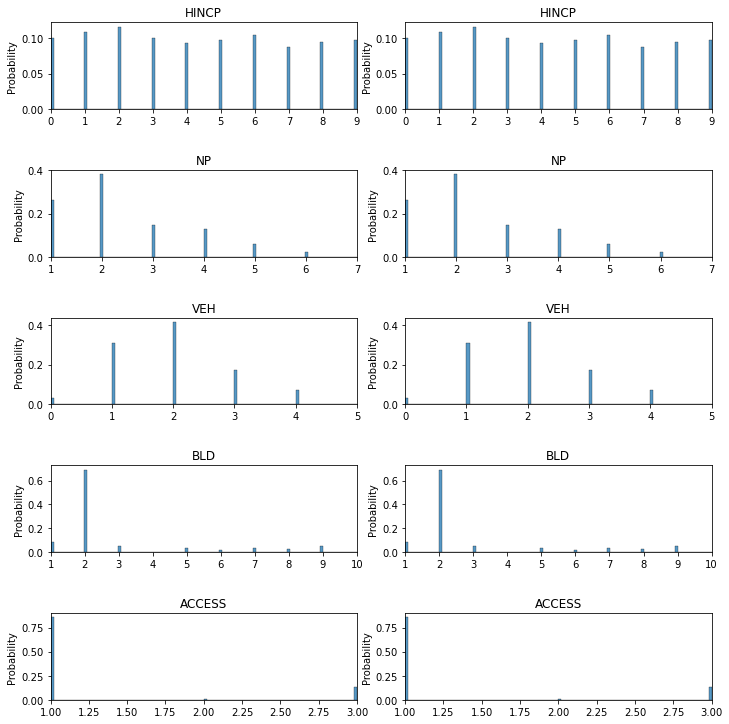

In [15]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,10))
fig.tight_layout(h_pad=4)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(test_results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(test_data_df[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)

## Generating Synthetic Population

In [16]:
# How many synthetic households to generate
POP_SIZE = 100000  # Number of hh in WA

# Generate random normal sample to represent each latent variable, for each row (different hh per row)
inputs = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

start_time = time.time()

# Generate households; each hh has unique latent input
results = vae.decoder.predict([inputs, inputs[:,LATENT_DIM:]])  # Nothing is actually in the second input

print(f"--- {time.time() - start_time} seconds ---")

--- 2.46812105178833 seconds ---


In [17]:
# Save raw output values to be conditional inputs for the person CVAE
synth_hh_ohe_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_ohe, 1, x)  # Most variables in PUMS are indexed from 1
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    synth_hh_ohe_df = pd.concat([synth_hh_ohe_df, result_df], axis=1)

synth_hh_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    synth_hh_df = pd.concat([synth_hh_df, result_df], axis=1)
synth_hh_df.columns = VAR_NAMES

synth_hh_df.to_csv('data/synthetic_populations/wa_households.csv', index=False)
synth_hh_ohe_df.to_csv('data/synthetic_populations/wa_households_raw.csv', index=False)

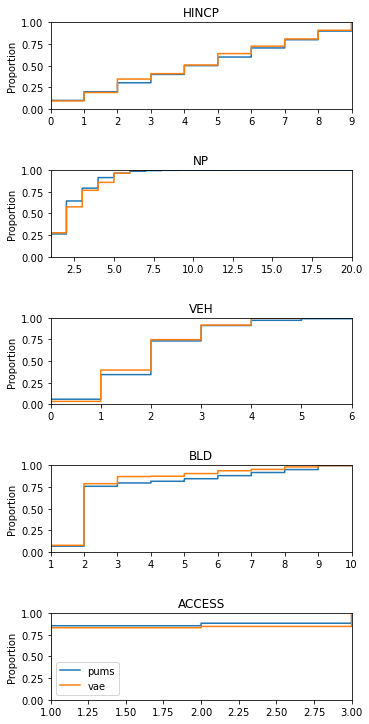

In [18]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=4)

for i, var in enumerate(VAR_NAMES):
    sns.ecdfplot(data=pums_data, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    sns.ecdfplot(data=synth_hh_df, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)
    plt.legend(labels=['pums','vae'])

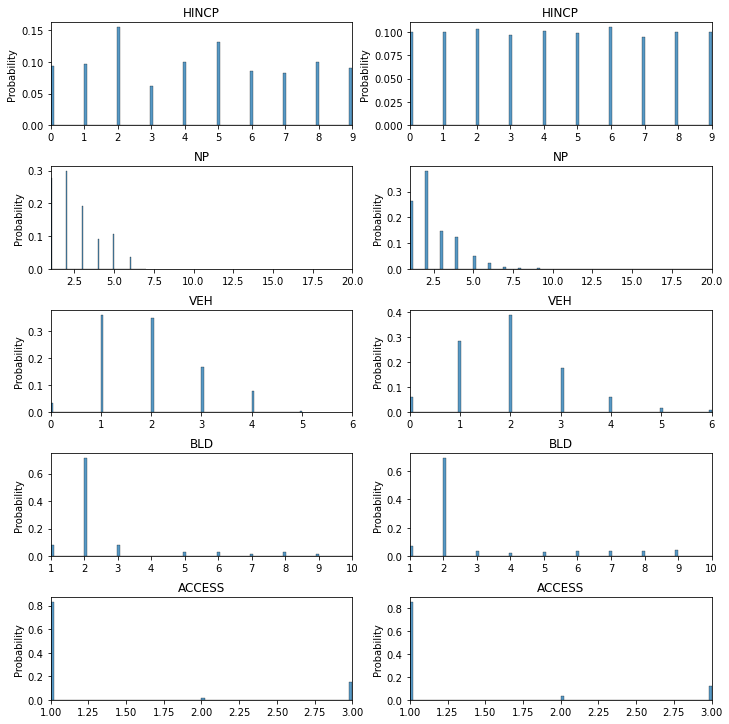

In [19]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,10))
fig.tight_layout(h_pad=2, w_pad=2)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(synth_hh_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(pums_data[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)

In [20]:
SRMSE.calculateSRMSE(synth_hh_df, pums_data.sample(POP_SIZE))
SRMSE.calculateBivariateSRMSE(synth_hh_df, pums_data.sample(POP_SIZE))

Univariate (marginal) SRMSE: 0.08192086800290084
Bivariate (joint) SRMSE: 0.03243663297133271


0.03243663297133271